In [5]:
#!pip install -q torch-scatter torch-sparse torch-geometric

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import Amazon
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv


Использую датасет Amazon-Computers для задачи классификации вершин.
Данные представляют собой граф товаров в категории компьютерной техники. Каждая вершина соответствует продукту с высокоразмерным признаковым описанием (bag-of-words), а ребра отражают совместные покупки товаров

In [6]:
transform = T.Compose([
    T.NormalizeFeatures(), # нормаизация признаков
    T.RandomNodeSplit(
        num_train_per_class=20, # то есть 20 узлов на класс в train
        num_val=500,          # 500 узлов на валидацию
        num_test=1000
    )
])

dataset = Amazon(root='data/Amazon', name='Computers', transform=transform)
data = dataset[0]

print(dataset)
print(data)
print('====================')
print(f'num_nodes:{data.num_nodes}')
print(f'num_edges:{data.num_edges}')
print(f'num_features:{dataset.num_features}')
print(f'num_classes:{dataset.num_classes}')
print(f'train_nodes:{int(data.train_mask.sum())}')
print(f'val_nodes:{int(data.val_mask.sum())}')
print(f'test_nodes:{int(data.test_mask.sum())}')


Processing...


AmazonComputers()
Data(x=[13752, 767], edge_index=[2, 491722], y=[13752], train_mask=[13752], val_mask=[13752], test_mask=[13752])
num_nodes:13752
num_edges:491722
num_features:767
num_classes:10
train_nodes:12252
val_nodes:500
test_nodes:1000


Done!


Базовая модель GCN на GCNConv

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)


In [9]:
def train_epoch(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def eval_accuracy(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[mask] == data.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc


In [10]:
hidden_channels = 64
lrs = [0.01, 0.005, 0.001]
num_epochs = 200

best_lr = None
best_val_acc = 0.0
results_by_lr = {}

In [11]:
for lr in lrs:
    print(f'\n= LR = {lr} =')
    model = GCN(hidden_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    best_val_for_this_lr = 0.0
    best_state_dict = None

    for epoch in range(1, num_epochs + 1):
        loss = train_epoch(model, optimizer, data)
        if epoch % 10 == 0 or epoch == 1:
            train_acc = eval_accuracy(model, data, data.train_mask)
            val_acc = eval_accuracy(model, data, data.val_mask)
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
                  f'TrainAcc: {train_acc:.4f}, ValAcc: {val_acc:.4f}')

        # ссохраняю лучшую модель по валидации для данного lr
        val_acc = eval_accuracy(model, data, data.val_mask)
        if val_acc > best_val_for_this_lr:
            best_val_for_this_lr = val_acc
            best_state_dict = model.state_dict()

    results_by_lr[lr] = best_val_for_this_lr

    # обновляю глобально лучший lr
    if best_val_for_this_lr > best_val_acc:
        best_val_acc = best_val_for_this_lr
        best_lr = lr
        best_global_state = best_state_dict

print("\nЛучший lr:", best_lr, "ValAcc:", best_val_acc)



= LR = 0.01 =


/tmp/ipython-input-3138951579.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return float(loss)


Epoch: 001, Loss: 2.3026, TrainAcc: 0.3746, ValAcc: 0.3580
Epoch: 010, Loss: 1.9738, TrainAcc: 0.3746, ValAcc: 0.3580
Epoch: 020, Loss: 1.9278, TrainAcc: 0.3746, ValAcc: 0.3580
Epoch: 030, Loss: 1.9117, TrainAcc: 0.3746, ValAcc: 0.3580
Epoch: 040, Loss: 1.9001, TrainAcc: 0.3746, ValAcc: 0.3580
Epoch: 050, Loss: 1.8891, TrainAcc: 0.3746, ValAcc: 0.3580
Epoch: 060, Loss: 1.8727, TrainAcc: 0.3746, ValAcc: 0.3580
Epoch: 070, Loss: 1.8522, TrainAcc: 0.3746, ValAcc: 0.3580
Epoch: 080, Loss: 1.8197, TrainAcc: 0.3746, ValAcc: 0.3580
Epoch: 090, Loss: 1.7810, TrainAcc: 0.3746, ValAcc: 0.3580
Epoch: 100, Loss: 1.7341, TrainAcc: 0.3753, ValAcc: 0.3600
Epoch: 110, Loss: 1.6869, TrainAcc: 0.3829, ValAcc: 0.3700
Epoch: 120, Loss: 1.6299, TrainAcc: 0.4185, ValAcc: 0.4020
Epoch: 130, Loss: 1.5854, TrainAcc: 0.4767, ValAcc: 0.4700
Epoch: 140, Loss: 1.5370, TrainAcc: 0.5137, ValAcc: 0.5200
Epoch: 150, Loss: 1.5022, TrainAcc: 0.5577, ValAcc: 0.5780
Epoch: 160, Loss: 1.4636, TrainAcc: 0.5832, ValAcc: 0.60

In [12]:
best_model = GCN(hidden_channels).to(device)
best_model.load_state_dict(best_global_state)

test_acc = eval_accuracy(best_model, data, data.test_mask)
print(f'Test Accuracy GCNConv: {test_acc:.4f}')


Test Accuracy GCNConv: 0.6450


Лучшие результаты модель показала при learning rate = 0.01 где валидационная точность достигла около 0.654. В то время как более низкие значения (0.005 и 0.001) обучались значительно медленнее и застряли на низком качестве (около 0.36–0.39 по валидационной точности). То есть более выоский lr позволил быстрее выйти из плато и эффективно оптимизировал веса пока мылые значения шагали слишком осторожно и не успели адаптироваться за 200 эпох.

Свой слой MyGCNConv по матричной формуле

In [13]:
from torch_geometric.utils import add_self_loops, degree


In [14]:
class MyGCNConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super().__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels, bias=False)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)

    def forward(self, x, edge_index):
        # x: [N, F_in]
        # edge_index: [2, E]

        N = x.size(0)

        # 1 добаляю self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=N)

        row, col = edge_index  # [E]

        # 2 считаю сткпент вершин
        deg = degree(row, num_nodes=N, dtype=x.dtype)  # [N]
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        # нормировка ребер
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]  # [E]

        # 3 линейное преобразование признаков
        x = self.lin(x)  # [N, F_out]

        #создаю разреженную матрицу признаков
        adj = torch.sparse_coo_tensor(
            edge_index,
            norm,
            (N, N)
        )

        out = torch.sparse.mm(adj, x)  # [N, F_out]

        if self.bias is not None:
            out = out + self.bias

        return out


In [15]:
#та же архитектура только вместо GCNConv использую MyGCNConv
class MyGCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = MyGCNConv(dataset.num_features, hidden_channels)
        self.conv2 = MyGCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [16]:
my_model = MyGCN(hidden_channels).to(device)
optimizer = torch.optim.Adam(my_model.parameters(), lr=best_lr, weight_decay=5e-4)

best_val = 0.0
best_state_my = None

for epoch in range(1, num_epochs + 1):
    loss = train_epoch(my_model, optimizer, data)
    if epoch % 10 == 0 or epoch == 1:
        train_acc = eval_accuracy(my_model, data, data.train_mask)
        val_acc = eval_accuracy(my_model, data, data.val_mask)
        print(f'[MyGCN] Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'TrainAcc: {train_acc:.4f}, ValAcc: {val_acc:.4f}')

    val_acc = eval_accuracy(my_model, data, data.val_mask)
    if val_acc > best_val:
        best_val = val_acc
        best_state_my = my_model.state_dict()

# финальный тест
my_best_model = MyGCN(hidden_channels).to(device)
my_best_model.load_state_dict(best_state_my)
test_acc_my = eval_accuracy(my_best_model, data, data.test_mask)

print(f'Test Accuracy (GCNConv): {test_acc:.4f}')
print(f'Test Accuracy (MyGCNConv): {test_acc_my:.4f}')


[MyGCN] Epoch: 001, Loss: 2.3026, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 010, Loss: 2.0326, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 020, Loss: 1.9370, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 030, Loss: 1.9241, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 040, Loss: 1.9162, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 050, Loss: 1.9112, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 060, Loss: 1.9003, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 070, Loss: 1.8890, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 080, Loss: 1.8668, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 090, Loss: 1.8452, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 100, Loss: 1.8189, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 110, Loss: 1.7805, TrainAcc: 0.3746, ValAcc: 0.3580
[MyGCN] Epoch: 120, Loss: 1.7444, TrainAcc: 0.3754, ValAcc: 0.3600
[MyGCN] Epoch: 130, Loss: 1.7113, TrainAcc: 0.3817, ValAcc: 0.3640
[MyGCN] Epoch: 140, Loss: 1.6692, TrainAcc: 0.3919, ValAcc: 0.

Модель GCNConv показала чуть более высокую точность на тестовой выборке 64.5%, чем реализация собственного слоя MyGCNConv -61.0%. Раализация собственного слоя хотя и близка по качеству, вероятно требует дальнейшей доработки (мб подобрать другую инициализцию)


In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [18]:
def visualize_embeddings(embeddings, labels, title=""):
    """
    embeddings: тензор [N, d] — эмбеддинги узлов
    labels: тензор [N] — классы узлов
    """
    emb = embeddings.detach().cpu().numpy()
    y = labels.detach().cpu().numpy()

    tsne = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=30, random_state=42)
    z = tsne.fit_transform(emb)

    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    scatter = plt.scatter(z[:, 0], z[:, 1], c=y, cmap="tab10", s=10)
    plt.title(title)
    plt.show()

In [19]:
@torch.no_grad()
def get_gcn_embeddings(model, data):
    model.eval()
    x = model.conv1(data.x, data.edge_index)
    x = F.relu(x)
    return x  # размер [N, hidden_channels]


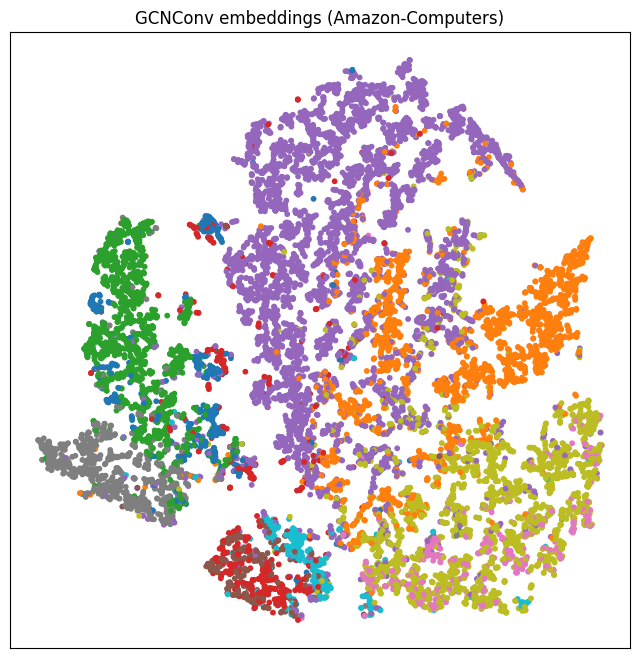

In [20]:
emb_gcn = get_gcn_embeddings(best_model, data)
visualize_embeddings(emb_gcn, data.y, title="GCNConv embeddings (Amazon-Computers)")


Модель сформировала достаточно хорошо отделенные обаости в пространстве эмбендингов: вершины одного класса преимущественно сгрупированны вместе, но некоторые зоны сильно пересекаются что возможно указывает о частичном сходстве их признаков, но в целом видна выраженная кластеризация